In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score, RocCurveDisplay, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from tensorflow import keras
from keras import layers, callbacks
from keras.optimizers import Adam

In [2]:
seed = 123
kfold = StratifiedKFold(10, shuffle=True, random_state=seed)

In [3]:
data = pd.read_csv("data/data.csv")
data.drop(columns=["Id"], inplace=True)
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,NaN,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,NaN,NaN,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
X = data.drop(columns=["quality"])
y = data["quality"]

In [5]:
# X = X_train + X_val -> for cross-validation
# X_val               -> for neural network
# train - 80%, val - 10%, test - 10%

X, X_test, y, y_test = train_test_split(X, y, train_size=0.9, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.888, random_state=seed)
print(X.shape)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(1028, 11)
(912, 11)
(116, 11)
(115, 11)


In [6]:
preprocessing = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("imputer", SimpleImputer())
    ]
)

scoring = "f1_weighted"

random_forest_grid = GridSearchCV(
    Pipeline(
        steps=[
            ("preprocessing", preprocessing),
            ("model", RandomForestClassifier())
        ]
    ),
    param_grid={
        "model__n_estimators": [50, 100, 250],
        "model__max_depth": [9, 12, 16, 21],
        "model__min_samples_split": [2, 4, 6]
    },
    scoring=scoring,
    cv=kfold,
    n_jobs=-1,
)

svc_grid = GridSearchCV(
    Pipeline(
        steps=[
            ("preprocessing", preprocessing),
            ("model", SVC())
        ]
    ),
    param_grid={
        "model__C": [0.1, 1, 10, 100, 1000],
    },
    scoring=scoring,
    cv=kfold,
    n_jobs=-1
)

knn_grid = GridSearchCV(
    Pipeline(
        steps=[
            ("preprocessing", preprocessing),
            ("model", KNeighborsClassifier())
        ]
    ),
    param_grid={
        "model__n_neighbors": [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60],
        "model__p": [1, 2],
        "model__weights": ["uniform", "distance"]
    },
    scoring=scoring,
    cv=kfold,
    n_jobs=-1
)

In [7]:
models = {
    "random_forest": random_forest_grid,
    "svc": svc_grid,
    "knn": knn_grid
}

for model_name, model in models.items():
    model.fit(X, y)
    print(model_name + " best params: ")
    print(model.best_params_)
    print(model_name + " score: ")
    print(model.best_score_)
    print()

C:\Users\Kamil\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(


random_forest best params: 
{'model__max_depth': 21, 'model__min_samples_split': 4, 'model__n_estimators': 100}
random_forest score: 
0.6335316892082284



C:\Users\Kamil\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(


svc best params: 
{'model__C': 10}
svc score: 
0.601125042632995



C:\Users\Kamil\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(


knn best params: 
{'model__n_neighbors': 20, 'model__p': 1, 'model__weights': 'distance'}
knn score: 
0.6182065250722922



In [8]:
X_train = pd.DataFrame(preprocessing.fit_transform(X_train))
X_val = pd.DataFrame(preprocessing.fit_transform(X_val))

X_train.head()

,0,1,2,3,4,5,6,7,8,9,10
0,-1.138366,-1.277245,1.127651,-0.539789,-0.404883,2.097550e-01,0.444111,-0.418136,0.790764,-3.677370e-16,-0.127945
1,-0.794087,1.158485,-1.198309,-0.163373,-0.768666,-8.662806e-01,-0.919913,-0.843462,0.855114,-1.490813e-01,0.987052
2,-0.105528,1.878133,-1.353373,0.589461,0.249926,9.923263e-01,0.444111,1.838168,1.820363,4.168688e-01,-0.592527
3,0.812549,-0.612955,1.024275,-0.313939,-0.283622,9.880084e-17,-0.919913,-0.112109,-0.303184,5.426355e-01,1.730383
4,-0.621947,-0.834385,0.197267,-0.539789,-0.307874,1.481433e+00,0.716916,0.074620,0.662065,-4.006147e-01,-0.871277


In [9]:
n = 256
neural_network = keras.Sequential([
    layers.Dense(n, input_shape=(X_train.shape[1],), activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(n, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(n, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(n, activation="relu"),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(n, activation="relu"),
    layers.Dense(11, activation="softmax"),
])

early_stopping = callbacks.EarlyStopping(
    min_delta=0.0001,
    patience=20,
    restore_best_weights=True,
)

neural_network.compile(
  optimizer=Adam(),
  loss="sparse_categorical_crossentropy",
  metrics=["sparse_categorical_accuracy"]
)

neural_network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               3072      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               6

Epoch 1/1000
29/29 [==============================] - 2s 13ms/step - loss: 1.8773 - sparse_categorical_accuracy: 0.3344 - val_loss: 2.0914 - val_sparse_categorical_accuracy: 0.4655
Epoch 2/1000
29/29 [==============================] - 0s 6ms/step - loss: 1.3092 - sparse_categorical_accuracy: 0.4539 - val_loss: 1.8960 - val_sparse_categorical_accuracy: 0.4828
Epoch 3/1000
29/29 [==============================] - 0s 6ms/step - loss: 1.2025 - sparse_categorical_accuracy: 0.4901 - val_loss: 1.6515 - val_sparse_categorical_accuracy: 0.5000
Epoch 4/1000
29/29 [==============================] - 0s 6ms/step - loss: 1.1889 - sparse_categorical_accuracy: 0.4934 - val_loss: 1.4652 - val_sparse_categorical_accuracy: 0.5345
Epoch 5/1000
29/29 [==============================] - 0s 5ms/step - loss: 1.1476 - sparse_categorical_accuracy: 0.5077 - val_loss: 1.3002 - val_sparse_categorical_accuracy: 0.5345
Epoch 6/1000
29/29 [==============================] - 0s 6ms/step - loss: 1.1152 - sparse_categoric

<AxesSubplot:>

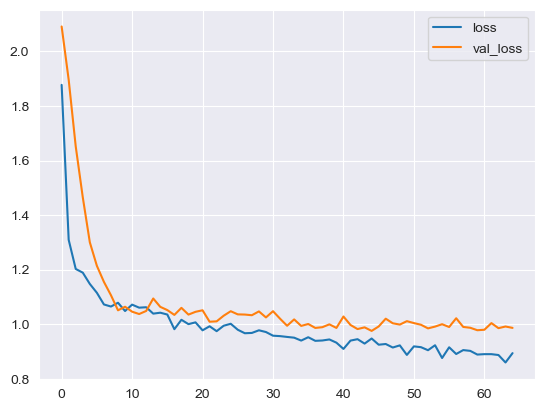

In [10]:
history = neural_network.fit(
  X_train, y_train,
  validation_data=(X_val, y_val),
  batch_size=32,
  epochs=1000,
  callbacks=[early_stopping],
  verbose=1,
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()

In [29]:
predictions = neural_network.predict(X_val)
predictions = predictions.argmax(axis=-1)
f1_score(y_val, predictions, average="weighted")

4/4 [==============================] - 0s 2ms/step


0.5862068965517241

In [28]:
models_test_scores = []

for model_name, model in models.items():
    models_test_scores.append((model_name, model.score(X_test, y_test)))
models_test_scores.append(("neural_network", f1_score(y_test, neural_network.predict(preprocessing.fit_transform(X_test))
                                                      .argmax(axis=-1), average="weighted")))

test_scores_df = pd.DataFrame(models_test_scores, columns=["model", "score"])
test_scores_df

4/4 [==============================] - 0s 2ms/step


,model,score
0,random_forest,0.731805
1,svc,0.641337
2,knn,0.705684
3,neural_network,0.664169


In [21]:
# the best model: random_forest
# I will examine its performance with a little more detail and visualizations

y_proba = random_forest_grid.predict_proba(X_test)
y_proba

array([[0.        , 0.0025    , 0.0797619 , 0.3827381 , 0.4675    ,
        0.0675    ],
       [0.        , 0.00678571, 0.61980159, 0.30199603, 0.05766667,
        0.01375   ],
       [0.01      , 0.073     , 0.5905    , 0.27758333, 0.04891667,
        0.        ],
       [0.        , 0.055     , 0.25702381, 0.44683333, 0.21364286,
        0.0275    ],
       [0.01      , 0.03072222, 0.35111111, 0.5455    , 0.06266667,
        0.        ],
       [0.03283333, 0.03      , 0.59183333, 0.302     , 0.04333333,
        0.        ],
       [0.        , 0.01      , 0.808     , 0.182     , 0.        ,
        0.        ],
       [0.        , 0.02095238, 0.60783333, 0.28788095, 0.08333333,
        0.        ],
       [0.01595238, 0.14145238, 0.5047619 , 0.26866667, 0.06916667,
        0.        ],
       [0.        , 0.025     , 0.67583333, 0.29416667, 0.005     ,
        0.        ],
       [0.        , 0.02033333, 0.864     , 0.10833333, 0.00733333,
        0.        ],
       [0.        , 0

In [22]:
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape

(115, 6)

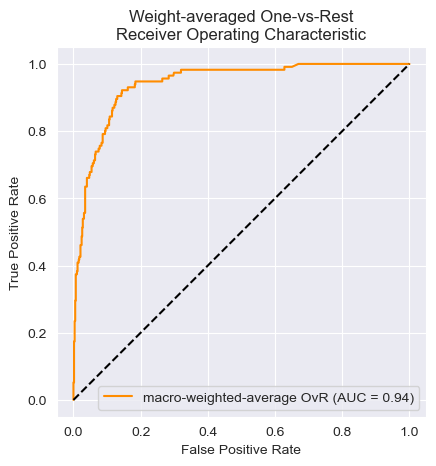

In [34]:
RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_proba.ravel(),
    name="macro-weighted-average OvR",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Weight-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.show()

In [46]:
y_test.value_counts()

5    60
6    42
7    10
4     2
3     1
Name: quality, dtype: int64

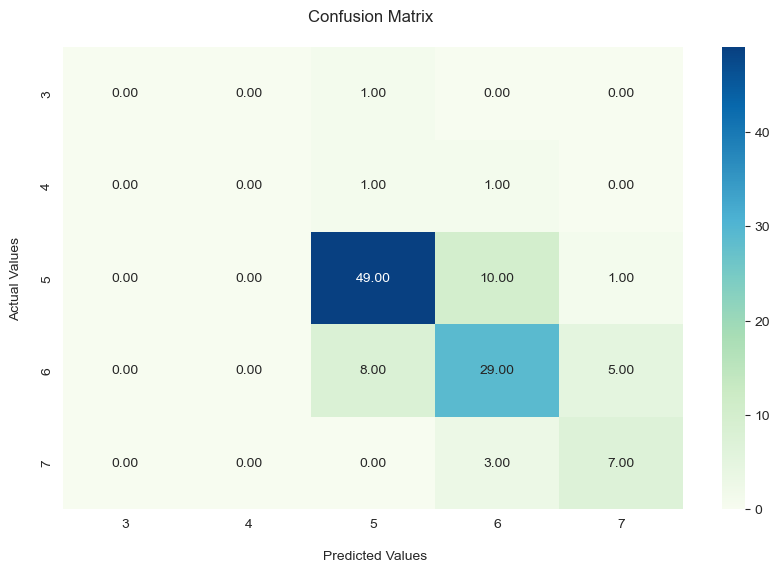

In [47]:
test_pred = random_forest_grid.predict(X_test)

plt.figure(figsize=(10,6))
fx=sns.heatmap(confusion_matrix(y_test,test_pred), annot=True, fmt=".2f",cmap="GnBu")
fx.set_title('Confusion Matrix \n')
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n')
fx.xaxis.set_ticklabels([3,4,5,6,7])
fx.yaxis.set_ticklabels([3,4,5,6,7])
plt.show()